In [1]:
import gym
import random
import numpy as np
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from time import time
from collections import deque 
from tensorflow.keras.models import load_model, clone_model
from gc import collect
from tensorflow.keras import backend as K



In [2]:
class DQ:
    def __init__(self, state_size, action_size,depth):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.001
        self.learning_rate = 0.001
        self.depth = depth
        self.model = self.build_model()
        #self.model.save('tmp_model')
        #self.guesser = load_model('tmp_model')
        self.guesser = clone_model(self.model)
        self.update_guesser()
        
        #print(self.model.get_weights())
        #print(self.guesser.get_weights())
    def huber_loss(self,a, b, in_keras=True):
        error = a - b
        quadratic_term = error*error / 2
        linear_term = abs(error) - 1/2
        use_linear_term = (abs(error) > 1.0)
        if in_keras:
            # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
            use_linear_term = K.cast(use_linear_term, 'float32')
        return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.depth, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.depth, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self.huber_loss, optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
        
    def act(self,state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = np.argmax(self.model.predict(state)[0])
        return act_values
    
    def update_guesser(self):
        #self.model.save('tmp_model')
        #self.guesser = load_model('tmp_model')
        #collect()
        self.guesser.set_weights(self.model.get_weights()) 
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma *np.amax(self.guesser.predict(next_state)[0])
            target_f = self.guesser.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        


In [7]:
class CartPole:
    def __init__(self,depth):
        self.depth = depth
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.scores = []  
        self.network_runs = []
        self.time_predictions = []
        self.time_stamps = []
        self.start = time()
        self.agent = DQ(self.state_size, self.action_size, self.depth)
        self.update_length = 1000
    def train(self,episodes):  
        self.agent.epsilon_decay = .9/(episodes*.2)
        
        for e in range(episodes):
            #print('a')
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            time_t = 0
            done = False
            while not done:
                time_t+=1
                #print('a')
                #env.render()
                action = self.agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                #reward = reward if not done else -.5
                next_state = np.reshape(next_state, [1, self.state_size])
                self.agent.remember(state, action, reward, next_state, done)
                state = next_state

            # print the score and break out of the loop
            if e % self.update_length == 0 and e > 0:
                print("episode: {}/{}, score: {}".format(e, episodes, time_t))
                time_per = (time()-self.start)/(e)
                time_pre = (time_per*(episodes-e))/3600
                print("Run Time:",'%.3f'%((time()-self.start)/3600),'hrs')
                print("Time Left:", '%.3f'%float(time_pre), 'hrs')
                self.time_stamps.append('%.3f'%((time()-self.start)/3600))
                self.time_predictions.append(time_pre)
                self.agent.update_guesser()
                #print(self.agent.epsilon)
                
            self.scores.append(time_t)
            if(len(self.agent.memory) > 32):
                self.agent.replay(32)
        self.env.close()
        
    def evaluate(self,games = 1):
        completed = 0
        env = gym.make(self.game_name)
        state = env.reset()
        state = np.resize(state, [1, self.state_size])
        while completed < games:
            start = time()
            env.render()
            action = self.agent.act(state)
            next_state, reward, done, _ = env.step(action)
            #reward = reward if not done else -.5
            next_state = np.reshape(next_state, [1, self.state_size])
            self.agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                completed += 1
                env.reset()
            sleep(.1-(time()-start))
        env.close()
carts = []
for depth in [2,12,24]:
    carts.append(CartPole(depth))
    carts[-1].train(100000)


episode: 1000/100000, score: 16
Run Time: 0.020 hrs
Time Left: 1.943 hrs
episode: 2000/100000, score: 12
Run Time: 0.040 hrs
Time Left: 1.939 hrs
episode: 3000/100000, score: 15
Run Time: 0.060 hrs
Time Left: 1.932 hrs
episode: 4000/100000, score: 23
Run Time: 0.081 hrs
Time Left: 1.943 hrs
episode: 5000/100000, score: 15
Run Time: 0.101 hrs
Time Left: 1.923 hrs
episode: 6000/100000, score: 10
Run Time: 0.121 hrs
Time Left: 1.900 hrs
episode: 7000/100000, score: 19
Run Time: 0.142 hrs
Time Left: 1.880 hrs
episode: 8000/100000, score: 16
Run Time: 0.162 hrs
Time Left: 1.858 hrs
episode: 9000/100000, score: 12
Run Time: 0.182 hrs
Time Left: 1.840 hrs
episode: 10000/100000, score: 22
Run Time: 0.202 hrs
Time Left: 1.818 hrs
episode: 11000/100000, score: 18
Run Time: 0.222 hrs
Time Left: 1.798 hrs
episode: 12000/100000, score: 30
Run Time: 0.243 hrs
Time Left: 1.778 hrs
episode: 13000/100000, score: 15
Run Time: 0.263 hrs
Time Left: 1.757 hrs
episode: 14000/100000, score: 11
Run Time: 0.28

episode: 12000/100000, score: 52
Run Time: 0.240 hrs
Time Left: 1.763 hrs
episode: 13000/100000, score: 21
Run Time: 0.264 hrs
Time Left: 1.767 hrs
episode: 14000/100000, score: 52
Run Time: 0.290 hrs
Time Left: 1.782 hrs
episode: 15000/100000, score: 84
Run Time: 0.319 hrs
Time Left: 1.807 hrs
episode: 16000/100000, score: 165
Run Time: 0.351 hrs
Time Left: 1.843 hrs
episode: 17000/100000, score: 213
Run Time: 0.392 hrs
Time Left: 1.912 hrs
episode: 18000/100000, score: 197
Run Time: 0.438 hrs
Time Left: 1.995 hrs
episode: 19000/100000, score: 245
Run Time: 0.489 hrs
Time Left: 2.083 hrs
episode: 20000/100000, score: 209
Run Time: 0.541 hrs
Time Left: 2.165 hrs
episode: 21000/100000, score: 180
Run Time: 0.603 hrs
Time Left: 2.268 hrs
episode: 22000/100000, score: 500
Run Time: 0.671 hrs
Time Left: 2.380 hrs
episode: 23000/100000, score: 500
Run Time: 0.745 hrs
Time Left: 2.494 hrs
episode: 24000/100000, score: 500
Run Time: 0.817 hrs
Time Left: 2.588 hrs
episode: 25000/100000, score:

episode: 23000/100000, score: 111
Run Time: 0.554 hrs
Time Left: 1.854 hrs
episode: 24000/100000, score: 115
Run Time: 0.587 hrs
Time Left: 1.860 hrs
episode: 25000/100000, score: 113
Run Time: 0.621 hrs
Time Left: 1.864 hrs
episode: 26000/100000, score: 116
Run Time: 0.654 hrs
Time Left: 1.862 hrs
episode: 27000/100000, score: 108
Run Time: 0.688 hrs
Time Left: 1.860 hrs
episode: 28000/100000, score: 111
Run Time: 0.722 hrs
Time Left: 1.857 hrs
episode: 29000/100000, score: 102
Run Time: 0.756 hrs
Time Left: 1.851 hrs
episode: 30000/100000, score: 121
Run Time: 0.790 hrs
Time Left: 1.844 hrs
episode: 31000/100000, score: 117
Run Time: 0.825 hrs
Time Left: 1.837 hrs
episode: 32000/100000, score: 109
Run Time: 0.859 hrs
Time Left: 1.826 hrs
episode: 33000/100000, score: 110
Run Time: 0.892 hrs
Time Left: 1.812 hrs
episode: 34000/100000, score: 103
Run Time: 0.926 hrs
Time Left: 1.797 hrs
episode: 35000/100000, score: 115
Run Time: 0.959 hrs
Time Left: 1.781 hrs
episode: 36000/100000, sc

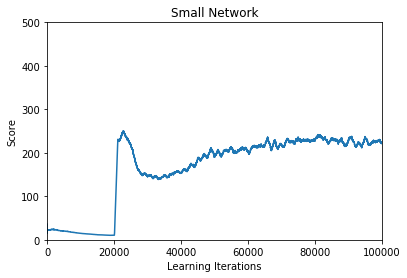

<Figure size 1440x720 with 0 Axes>

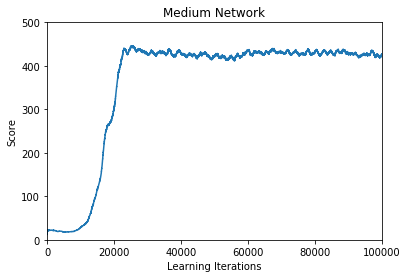

<Figure size 1440x720 with 0 Axes>

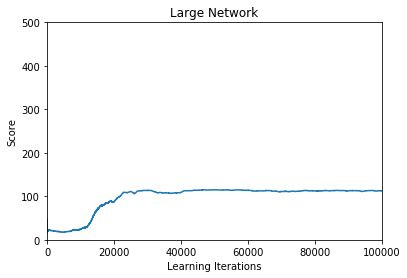

<Figure size 1440x720 with 0 Axes>

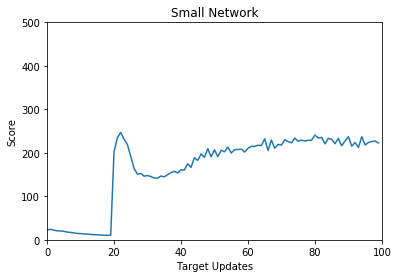

<Figure size 1440x720 with 0 Axes>

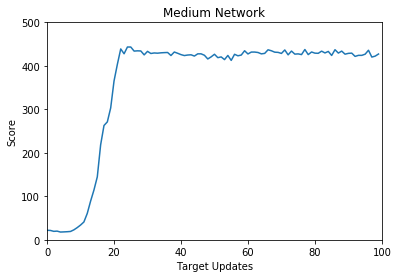

<Figure size 1440x720 with 0 Axes>

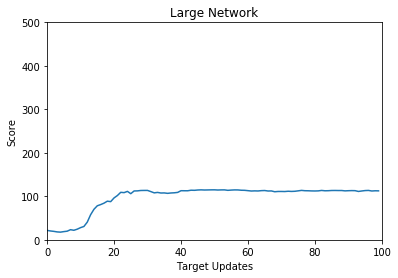

<Figure size 1440x720 with 0 Axes>

In [10]:

class CartPole_Grapher:
    def __init__(self,carts):
        self.carts = carts
        self.max = 500
    def moving_avg(self,lis,tail_p):
        curr = 0
        tail = max([1,int(len(lis)*tail_p)])
        m_lis = []
        for i in range(len(lis)):
            if i >= tail:
                if i > 0:
                    curr *= tail
                    curr -= lis[i-tail]
                    curr += lis[i]
                    curr /= tail
                else:
                    curr = lis[i]

            else:
                if i > 0:
                    curr *= i-1
                    curr += lis[i]
                    curr /= i
                else:
                    curr = lis[i]
            m_lis.append(curr)
        return m_lis
    def sub_graph(self, tail_p, names):
        plot = 0
        rows = np.ceil(len(carts)/2)
        for cart in self.carts:
            
            plt.subplot(2,2,plot+1)
            plt.axis([0, len(cart.scores), 0, self.max])
            plt.plot(self.moving_avg(cart.scores,tail_p))
            plt.title(names[plot])
            plt.figure(figsize=(20,10))
            
            
            plot += 1
        plt.show()  
        
    def graph(self, tail_p, names):
        plot = 0
        rows = np.ceil(len(carts)/2)
        for cart in self.carts:
            
            plt.axis([0, len(cart.scores), 0, self.max])
            plt.xlabel("Learning Iterations")
            plt.ylabel("Score")
            plt.title(names[plot])
            plt.plot(self.moving_avg(cart.scores,tail_p))
            plt.figure(figsize=(20,10))
            
            plot +=1
            plt.show()   
    def chunk_graph(self,chunk_length,names):
        cart_num = 0
        for cart in self.carts:
            avgs = []
            for chunk in range(int(len(cart.scores)/chunk_length)):
                temp = 0
                for i in range(chunk_length):
                    temp += cart.scores[chunk*chunk_length+i]
                avgs.append(temp/chunk_length)
            plt.axis([0, int(len(cart.scores)/chunk_length), 0, 500])
            plt.xlabel("Target Updates")
            plt.ylabel("Score")
            plt.title(names[cart_num])
            plt.plot(avgs)
            plt.figure(figsize=(20,10))
            plt.show()   
            cart_num +=1
                
        
            
cpg = CartPole_Grapher(carts)
cpg.graph(0.01, names = [size + ' Network' for size in ['Small', 'Medium', 'Large']])
#cpg.graph(.01, names = [size + ' Network' for size in ['Medium']])
cpg.chunk_graph(1000, names = [size + ' Network' for size in ['Small', 'Medium', 'Large']])


In [ ]:
'''import matplotlib.pyplot as plt
temp = 0
ascores = []
avg = 50
for i in range(len(scores2)):
    if i%avg == 0 and i != 0:
        ascores.append(temp/avg)
        temp = 0
    else:
        temp += scores2[i]
 
def plot(x):
    plt.plot(range(len(x)),x)
    plt.show()
plot(ascores)'''

 
'''depths = ['Large','Medium','Small']
training_length = ['Short','Medium','Long']
avg = 100
plots = []
plt.figure(figsize=(20,10))
for run in network_runs:
    temp_plot = []
    temp = 0
    for i in range(int(len(run))):
        temp += run[i]
        if i % avg == 0:
            temp_plot.append(temp/avg)
            temp = 0
    plots.append(temp_plot)
for plot in range(len(plots)):
    plt.subplot(3, 3, plot+1)
    plt.plot(plots[plot])
    #title = depths[run%3]+' Nework with '+training_length[int(run/3)]+' Training Period'
    title = depths[plot%3]+' Nework'
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Training_Batches')
plt.show()  '''

In [6]:
'''import numpy as np
import matplotlib.pyplot as plt


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(2, 2, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 2, 4)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.show()'''

"import numpy as np\nimport matplotlib.pyplot as plt\n\n\nx1 = np.linspace(0.0, 5.0)\nx2 = np.linspace(0.0, 2.0)\n\ny1 = np.cos(2 * np.pi * x1) * np.exp(-x1)\ny2 = np.cos(2 * np.pi * x2)\n\nplt.subplot(2, 2, 1)\nplt.plot(x1, y1, 'o-')\nplt.title('A tale of 2 subplots')\nplt.ylabel('Damped oscillation')\n\nplt.subplot(2, 2, 4)\nplt.plot(x2, y2, '.-')\nplt.xlabel('time (s)')\nplt.ylabel('Undamped')\n\nplt.show()"

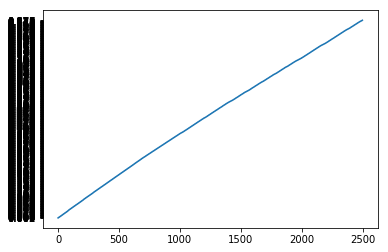

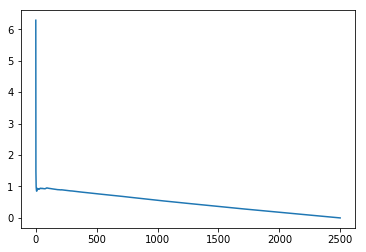

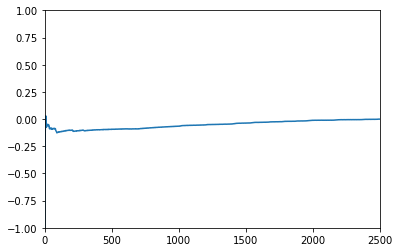

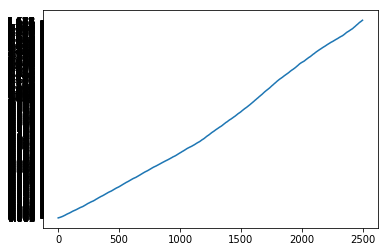

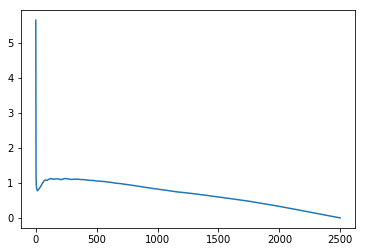

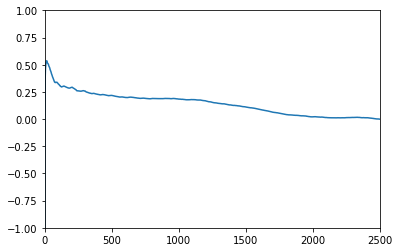

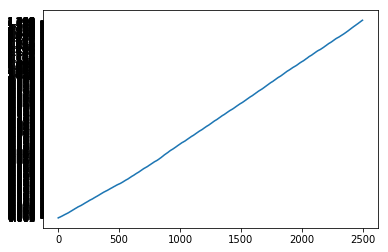

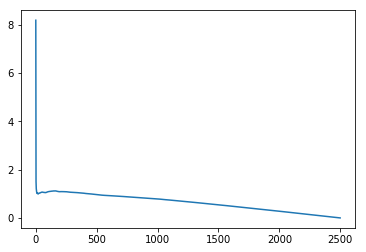

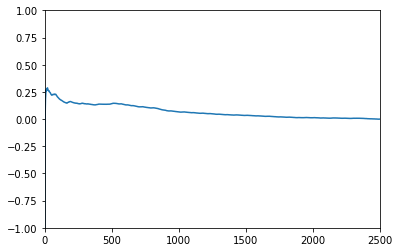

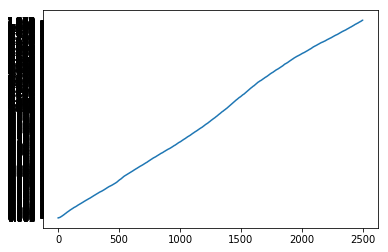

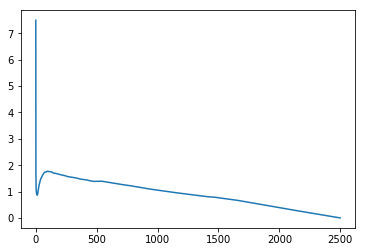

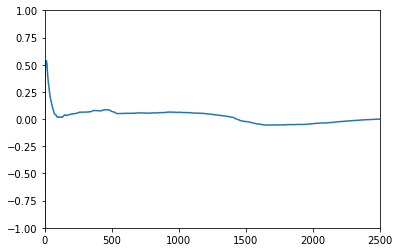

In [9]:
for c in range(len(carts)):    
    plt.plot(carts[c].time_stamps)
    plt.show()
    plt.plot(carts[c].time_predictions)
    plt.show()
    error = []
    for i in range(len(carts[c].time_stamps)):
        error.append((float(carts[c].time_stamps[-1])-float(carts[c].time_predictions[i])-float(carts[c].time_stamps[i]))/float(carts[c].time_stamps[-1]))
    plt.plot(error)
    plt.axis([0,2500,-1,1])
    plt.show()
    error_short = error[30:]
    #for i in error_short:
        #print(i)

In [11]:
carts[-1].evaluate()

AttributeError: 'CartPole' object has no attribute 'game_name'